# Generating Conditional Wigner Functions with MrMustard
## Objective

In this notebook, we demonstrate how to:

- Construct a small continuous-variable quantum circuit using squeezed vacuum states and beam splitters.
- Apply photon-number-resolving measurements to generate non-Gaussian conditional states.
- Compute and visualize the Wigner function of the resulting conditional state.

This will serve as the starting point for generating datasets to train a neural network for inverse circuit design.

In [13]:
import numpy as np
from mrmustard.lab import Circuit, Interferometer, SqueezedVacuum, Number
from mrmustard.lab.transformations import BSgate, Sgate, Dgate
from mrmustard.physics.wigner import wigner_discretized
import matplotlib.pyplot as plt

## Generate a state with random circuit parameters¶

In [2]:
seed = 42
rng = np.random.default_rng(seed)

#Set number of modes, maximal squeezing and maximal number of photons detected
N = 3
# Note: larger squeezing and higher photon numbers lead to rarer events
# and noisier conditional states
max_r = 0.8  # recommended bound for tractable simulation
max_n = 3

#Generate input squeezed states

squeezing_params = rng.uniform(0, max_r, size=N)
input_state = [
    SqueezedVacuum(i, r, phi=(0 if i % 2 == 1 else np.pi/2))
    for i, r in enumerate(squeezing_params)
]

#Generate interferometer randomly
def random_BS(mode1,mode2):
    #Mixing angle
    theta = rng.uniform(0, np.pi/2)
    #Relative phase
    phi = rng.uniform(0, 2*np.pi)
    BS = BSgate([mode1,mode2],theta,phi)
    return BS, [theta, phi]

# Three beam splitters are sufficient to generate an arbitrary 3-mode interferometer.
# Students are encouraged to experiment with fewer or more.
BS1, BS1_params = random_BS(0,1)
BS2, BS2_params = random_BS(1,2)
BS3, BS3_params = random_BS(0,1)
BS_params = [BS1_params, BS2_params, BS3_params]

interferometer = BS1 >> BS2 >> BS3

#Generate random measurement numbers
photon_numbers = rng.integers(0, max_n + 1, size=N-1)

params = {
    "squeezing": squeezing_params,
    "beam_splitters": BS_params,
    "photon_numbers": photon_numbers,
}

measurement = [Number(i, n).dual for i, n in enumerate(photon_numbers)]

#Realize cirquit and get output state (out)
c = Circuit(input_state) >> interferometer >> Circuit(measurement)
out = c.contract().normalize()

#Print information
print("Circuit parameters:")
for k, v in params.items():
    print(f"  {k}: {v}")

Circuit parameters:
  squeezing: [0.61916484 0.35110275 0.68687834]
  beam_splitters: [[1.0954231384706454, 0.5917337285168199], [1.532504006290015, 4.782381792256834], [1.2347469233536212, 0.8049616944763924]]
  photon_numbers: [3 1]


/home/lcgho/qst-hack2026/.venv/lib/python3.13/site-packages/mrmustard/physics/ansatz/array_ansatz.py:260: UserWarning: The fock array is being padded with zeros. Is this really necessary?
  warn(


In [3]:
display(out)

/home/lcgho/qst-hack2026/.venv/lib/python3.13/site-packages/mrmustard/physics/ansatz/array_ansatz.py:260: UserWarning:

The fock array is being padded with zeros. Is this really necessary?



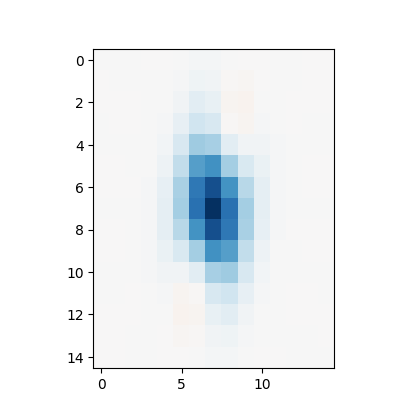

In [4]:
#Adjust format of pixelized wigner function
x = 3.0      # phase-space cutoff
Np = 15      # number of pixels per axis
xvec = np.linspace(-x, x, Np)
pvec = np.linspace(-x, x, Np)
wig, X, P = wigner_discretized(out.dm().ansatz.array, xvec, pvec)

plt.imshow(wig.T, vmin=-1/np.pi, vmax=1/np.pi, cmap='RdBu')

## Next Steps / Challenge

- Try changing the squeezing parameters, beam splitter angles, or photon numbers and observe how the Wigner function changes.
- Think about how you could generate a dataset of many such Wigner functions and store the corresponding circuit parameters for NN training.
- Consider the impact of low-probability measurement outcomes on the dataset.
- ...

## Extra: Play with the circuit parameters to generate a state

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Cutoff and max values
N = 3
max_r = 0.8
max_n = 3

In [15]:
# Function to build the circuit interactively
def circuit(r0, r1, r2, theta1, phi1, theta2, phi2, theta3, phi3, n0, n1):
    
    # Input squeezed states
    squeezing_params = [r0, r1, r2]
    input_state = [
        SqueezedVacuum(i, r, phi=(0 if i % 2 == 1 else np.pi/2))
        for i, r in enumerate(squeezing_params)
    ]
    
    # Interferometer
    BS1 = BSgate([0,1], theta1, phi1)
    BS2 = BSgate([1,2], theta2, phi2)
    BS3 = BSgate([0,1], theta3, phi3)
    interferometer = BS1 >> BS2 >> BS3
    
    # Measurement (post-selection)
    photon_numbers = [n0, n1]
    measurement = [Number(i, n).dual for i, n in enumerate(photon_numbers)]
    
    # Build and run circuit
    c = Circuit(input_state) >> interferometer >> Circuit(measurement)
    out = c.contract().normalize()
    
    display(out)

# Sliders for squeezing
r_sliders = [widgets.FloatSlider(min=0, max=max_r, step=0.01, value=0.5, description=f'r{i}') for i in range(3)]

# Sliders for beam splitters
theta_sliders = [widgets.FloatSlider(min=0, max=np.pi/2, step=0.01*np.pi, value=np.pi/4, description=f'theta{i+1}') for i in range(3)]
phi_sliders   = [widgets.FloatSlider(min=0, max=2*np.pi, step=0.01*np.pi, value=0, description=f'phi{i+1}') for i in range(3)]

# Sliders for photon numbers
n_sliders = [widgets.IntSlider(min=0, max=max_n, step=1, value=0, description=f'n{i}') for i in range(2)]

# Interactive widget
interactive_plot = widgets.interactive(
    update_circuit,
    r0=r_sliders[0], r1=r_sliders[1], r2=r_sliders[2],
    theta1=theta_sliders[0], phi1=phi_sliders[0],
    theta2=theta_sliders[1], phi2=phi_sliders[1],
    theta3=theta_sliders[2], phi3=phi_sliders[2],
    n0=n_sliders[0], n1=n_sliders[1]
)

display(interactive_plot)

interactive(children=(FloatSlider(value=0.5, description='r0', max=0.8, step=0.01), FloatSlider(value=0.5, des…